# Model Evaluation Approach

This is the initial notebook that describes our model evaluation approach in finding the optimal model for our use case, fetal health evaluation. We'll dive through the different steps and techniques implemented for model evaluation:
1. Data Preprocessing
2. Model Training
3. Evaluation
4. Saving the Best Model

We'll also establish baseline metrics using a dummy classifier that always predicts the most frequent class.

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, make_scorer, classification_report
import pyprojroot
import pickle

We set a random seed for reproducibility.

In [3]:
RANDOM_STATE = 11

## 1. Data Preprocessing

In [4]:
DATA_PATH = pyprojroot.here().joinpath('data', 'fetal_health.csv')
df = pd.read_csv(DATA_PATH)

In [5]:
X = df[df.columns.difference(['fetal_health', 'fetal_health_label'])]
y = df['fetal_health']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=RANDOM_STATE)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Defining our Metrics

In [121]:
# Creating labels for target variable
label_mapping = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}
df['fetal_health_label'] = df['fetal_health'].map(label_mapping)

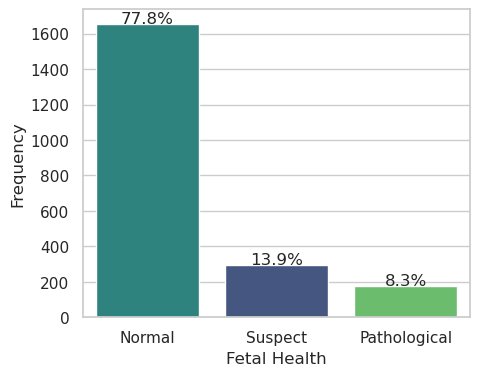

In [122]:
sns.set_theme(style="whitegrid", font_scale=1)

plt.figure(figsize=(5,4))

# Creates a barplot for 'fetal_health_label' variable
class_order = ['Normal', 'Suspect', 'Pathological']
ax = sns.countplot(x='fetal_health_label', hue='fetal_health_label', legend=False, data=df, palette='viridis', order=class_order)

# Annotates percentages to bars
total = len(df)
for i, patch in enumerate(ax.patches):
   x_pos = patch.get_x() + patch.get_width()/2
   y_pos = patch.get_height()+2
   ax.annotate('{:.1f}%'.format(100*patch.get_height()/total), (x_pos, y_pos), ha='center')

plt.xlabel('Fetal Health')
plt.ylabel('Frequency')

plt.show()

As we can see in the figure above, the classes are greatly disbalanced. This means that accuracy will not be sufficient in evaluating performance across all classes. Regardless, we'll include accuracy to our metrics as a baseline.

Given that we are building a sickness prediction model, we prioritize identifying cases that represent sickness presence. Thus, we'll pay special attention to the **recall** metric of the classes that represent or may sickness, which are 'suspect' and 'pathological'.

**Balanced accuracy** accounts for the issue of imbalanced classes and calculates the average of recall obtained on each class. This will be our main metric used to optimize our models

Other robust metrics that will guide us through our evaluation are the **F1 score** and **Area under the ROC curve (AUC)**.

---
We'll use Macro-Averaging as it gives equal weights to each class. It over-emphasizes low performance on infrequent classes.

In [123]:
# We pass a metrics dictionary to the cross_validate function instead of a list
# because some metrics need further configuration, such as an averaging method.
metrics = {
    'accuracy': accuracy_score,
    'balanced_accuracy': balanced_accuracy_score, 
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0),
    'f1_score': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro', zero_division=0)
}

# Scorers are metrics that receive an 'estimator' parameter as well
# We need to provide scorer functions instead of metrics for cross_validate.
for key in metrics.keys():
    metrics[key] = make_scorer(metrics[key])

## 2. Model Training

We tune our hyperparameters with GridSearchCV, which conducts an exhaustive search over specified parameter values of an estimator. It optimizes the specified metric, balanced accuracy in this case, with cross-validation.

In [48]:
# We define our parameters dictionary
params = {
    "strategy": ["most_frequent", "prior", "stratified", "uniform"],
    "random_state": [RANDOM_STATE]
}

In [98]:
# Execute Grid Search
grid_search = GridSearchCV(estimator=DummyClassifier(), param_grid=params, scoring=metrics["recall"],\
    cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE))
grid_search.fit(X_train_scaled, y_train)

# Save results in dataframe for visualization
grid_df = pd.DataFrame(grid_search.cv_results_)

In [130]:
# Results are given such that each row corresponds to grid search iteration.
# Here we extract only the columns that contain the parameters used for the iteration
# and the mean test score.
sum_cols = [f"param_{param}" for param in list(params.keys())]
sum_cols.append('mean_test_score')
grid_df[sum_cols].sort_values(by="mean_test_score", ascending=False)

,param_strategy,param_random_state,mean_test_score
3,uniform,11,0.344863
2,stratified,11,0.339529
0,most_frequent,11,0.333333
1,prior,11,0.333333


Now, we use the best estimator found by the algorithm to run a more rigorous evaluation of the model over a larger set of metrics

In [106]:
dummy_clf = grid_search.best_estimator_
dummy_clf

DummyClassifier(random_state=11, strategy='uniform')

## 3. Evaluation

We're using cross validation to precisely evaluate model performance, independent from random data partitions, which may influence our metrics.

In [115]:
cv_result = cross_validate(dummy_clf, X_test_scaled, y_test, scoring=metrics,\
    cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE), return_estimator=True)
cv_result_df = pd.DataFrame(cv_result)

In [117]:
cv_result_df = cv_result_df.drop('estimator', axis=1)
cv_result_df.mean()

fit_time                  0.001110
score_time                0.016371
test_accuracy             0.370653
test_balanced_accuracy    0.310555
test_recall               0.310555
test_precision            0.324401
test_f1_score             0.266698
dtype: float64

We can see that dummy classifier has very low performance. These will be our baseline metrics.

In [124]:
y_pred = dummy_clf.predict(X_test_scaled)

In [125]:
labels = list(label_mapping.keys())
target_names = list(label_mapping.values())

In [126]:
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

      Normal       0.81      0.34      0.48       332
     Suspect       0.16      0.41      0.23        59
Pathological       0.06      0.26      0.10        35

    accuracy                           0.35       426
   macro avg       0.35      0.34      0.27       426
weighted avg       0.66      0.35      0.42       426



Here, we can see in more detail our metrics calculated per class.

## 4. Saving the Model

We're using the _pickle_ library for saving our models.

In [128]:
MODEL_PATH = pyprojroot.here().joinpath('models', 'dummy_clf.pkl')

# Save the model
with open(MODEL_PATH,'wb') as f:
    pickle.dump(grid_search.best_estimator_,f)